# 20211012-zhan-statistics
Evaluate IPCs, accuracy, and coverage over simpoints for the base prefetchers, for *Zhan's traces*.

In [1]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import attrdict
import matplotlib.pyplot as plt

from utils.load import load_simpoint_weights, parse_champsim_result_file, load_champsim_base_results, parse_paper_result_file

---
# User parameters.

You can look at the simpoint-weights or the data to get the trace_id for the trace you want.

In [2]:
simpoints_dir = 'data/simpoint-weights/'
results_dir = 'data/zhan-prefetch1-fixedcache-250m/'
max_instruction_num = 250   # in millions
min_instruction_interval = 0 # in millions (this does not affect IPC results much)
verbose = True

---
# Load and preprocess results.
- `ml_prefetch_sim.py eval --results-dir <>`

In [3]:
stats = pd.read_csv(results_dir + 'stats.csv')
stats.Trace = stats.Trace.map(lambda t: t.split('.')[0].split('_')[0])
#stats

In [4]:
# Add Offline UAC metrics to the table
diffs = pd.read_csv(results_dir + 'diff.csv')
diffs.Trace = diffs.Trace.map(lambda t: t.split('_')[0])
diffs['Offline_UAC'] = (1 - diffs['diff12']) * 100.
diffs.loc[diffs['diff12'] == 0, 'Offline_UAC'] = 0. # Set to 0 for BO traces that don't do any prefetches (e.g. mcf)
offline_uacs = diffs[['Trace', 'Baseline', 'Offline_UAC']]
offline_uacs = offline_uacs[offline_uacs['Baseline'].isin(['sisb', 'bo'])]
diffs

,Trace,Baseline,diffs,diff1,diff2,diff12,diffs_raw,diff1_raw,diff2_raw,diff12_raw,total_keys,Offline_UAC
0,astar,pc_sisb,0.607684,0.007045,0.000011,0.600628,3475879,40297,65,3435517,5719877,39.937222
1,astar,sisb,0.609853,0.002800,0.000013,0.607040,3488292,16018,76,3472198,5719888,39.296049
2,astar,bo,1.000000,0.827567,0.000002,0.172431,5719823,4733537,11,986275,5719823,82.756896
3,bfs,pc_sisb,0.313430,0.026646,0.000055,0.286730,1089939,92659,191,997089,3477451,71.327015
4,bfs,sisb,0.396002,0.012701,0.000058,0.383242,1377081,44168,203,1332710,3477463,61.675796
5,bfs,bo,1.000000,0.008228,0.000060,0.991713,3477467,28612,207,3448648,3477467,0.828735
6,cc,pc_sisb,0.593150,0.065890,0.000041,0.527219,1836128,203965,126,1632037,3095556,47.278066
7,cc,sisb,0.600118,0.064435,0.000041,0.535642,1857701,199462,128,1658111,3095558,46.435796
8,cc,bo,1.000000,0.000000,0.000041,0.999959,3095558,0,128,3095430,3095558,0.004135
9,mcf,pc_sisb,0.473646,0.221719,0.000003,0.251924,9436326,4417256,58,5019012,19922735,74.807616


In [5]:
stats = pd.merge(stats, offline_uacs, how='outer')
stats

,Trace,Baseline,Accuracy,Coverage,Coverage_Old,UAC,MPKI,MPKI_Improvement,IPC,IPC_Improvement,Offline_UAC
0,bfs,no,NaN,NaN,NaN,NaN,10.649808,NaN,0.400746,NaN,NaN
1,bfs,bo,68.240373,58.313389,61.543558,23.298645,4.439544,58.428371,0.531870,32.719977,0.828735
2,bfs,sisb,89.280508,66.323900,67.676684,53.909231,3.586440,66.416787,0.562613,40.391420,61.675796
3,bfs,sisb_bo,88.699359,67.024344,68.364262,53.245199,3.511844,67.115299,0.565536,41.120810,NaN
4,mcf,no,NaN,NaN,NaN,NaN,70.754244,NaN,0.098313,NaN,NaN
5,mcf,bo,70.779977,0.006196,0.006874,0.000000,70.749860,0.180699,0.098320,0.007832,0.000000
6,mcf,sisb,77.068077,39.514899,39.614023,39.506586,42.795776,39.620454,0.138215,40.587270,61.876227
7,mcf,sisb_bo,77.100043,39.595589,39.695572,39.470659,42.738684,39.701004,0.138261,40.634059,NaN
8,astar,no,NaN,NaN,NaN,NaN,43.239336,NaN,0.115519,NaN,NaN
9,astar,bo,69.320599,5.150625,5.394529,0.489469,41.012240,5.198956,0.116933,1.224041,82.756896


---
# Plotting / table helpers
**TODO** Break out into a utils file

Value plot: Expect BO, ISB bars to match closely to Paper BO, Paper ISB bars.

In [6]:
def plot_results(df, column, y_label, subtitle=None, paper_data=None, factor = 1., ymin=None, ymax=None, legend=True, plot_baseline=False):
    """Plot data for a
    list of prefetchers and traces.
    """
    traces = sorted(set(df.Trace))
    fig, ax = plt.subplots(dpi=196)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    sep = 1
    if paper_data:
        step_size = 0.125 #0.1
        width = 0.1 #0.075
    else:
        step_size = 0.2
        width = 0.15
        
    for i, tr in enumerate(traces):
        tr_data = df[df.Trace == tr]
        nsteps = 0 # Tracks where to place each bar
        
        ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column], 
               color='C0', width = width, 
               label='BO' if i == 0 else ''
        )
        nsteps += 1
        
        ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column], 
               color='C1', width=width, 
               label='SISB' if i == 0 else ''
        )
        nsteps += 1
            
#         ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb_bo'][column], 
#                color='C2', width=width, 
#                label='ISB + BO' if i == 0 else ''
#         )
#         nsteps += 1
        
        if paper_data and tr in paper_data:
            ax.bar(i*sep + nsteps*step_size, paper_data[tr]['Paper-BO'] * factor, 
                   color='C0', alpha=0.25, width=width, #edgecolor='C0',
                   label='Paper BO' if i == 0 else ''
            )
            nsteps += 1
                
            ax.bar(i*sep + nsteps*step_size, paper_data[tr]['Paper-ISB'] * factor, 
                   color='C1', alpha=0.25, width=width, #edgecolor='C1', 
                   label='Paper ISB' if i == 0 else ''
            )
            nsteps += 1
                
            ax.bar(i*sep + nsteps*step_size, paper_data[tr]['Paper-Voyager'] * factor, 
                   color='C3',  alpha=0.25, width=width, #edgecolor='C3',
                   label='Paper Voyager' if i == 0 else ''
            )
            nsteps += 1
                
        if plot_baseline:
            ax.bar(i*sep + nsteps*step_size, tr_data[df.Baseline == 'no'][column] * factor, 
                   color='gray', alpha=0.25, width=width, #edgecolor='gray',
                   label='No prefetcher' if i == 0 else ''
            )
            nsteps += 1
            
    if legend:
        ax.legend()
    ax.set_xticks(np.arange(0, len(traces)) + (nsteps*width/2))
    ax.set_xticklabels(traces, fontdict={'size': 7})
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(column)
    ax.set_ylabel(y_label)
    ax.set_ylim(ymin=ymin, ymax=ymax)

Delta Plot
- Expect BO vs. ISB bar to match closely to Paper BO vs. Paper ISB bars (green)
- Expect BO vs. Paper BO (blue) and ISB vs. Paper ISB (yellow) bars to be close to zero.

In [7]:
def plot_deltas(df, column, y_label, subtitle=None, paper_data=None, factor = 1., ymin=None, ymax=None, legend=True, plot_baseline=False):
    """Plot differences in columns for a
    list of prefetchers and traces.
    """
    traces = sorted(set(df.Trace))
    fig, ax = plt.subplots(dpi=196)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    sep = 1
    if paper_data:
        step_size = 0.15 #0.1
        width = 0.125 #0.075
    else:
        step_size = 0.2
        width = 0.15
        
    for i, tr in enumerate(traces):
        tr_data = df[df.Trace == tr]
        nsteps = 0 # Tracks where to place each bar
        
        sisb = tr_data[df.Baseline == 'sisb'][column].iat[0]
        bo = tr_data[df.Baseline == 'bo'][column].iat[0]
        pisb = paper_data[tr]['Paper-ISB'] * factor
        pbo = paper_data[tr]['Paper-BO'] * factor

        
        ax.bar(i*sep, sisb - bo, 
               color='C2', width = width, 
               label='SISB vs. BO' if i == 0 else ''
        )
        nsteps += 1
        
        if paper_data and tr in paper_data:
            ax.bar(i*sep + nsteps*step_size, pisb - pbo, 
                   color='C2', alpha=0.25, width=width, #edgecolor='C0',
                   label='Paper ISB vs. Paper BO' if i == 0 else ''
            )
            nsteps += 1
                

            ax.bar(i*sep + nsteps*step_size,  bo - pbo,
                   color='C0', alpha=0.25, width=width, #edgecolor='C0',
                   label='BO vs. Paper BO' if i == 0 else ''
            )
            nsteps += 1
  
            ax.bar(i*sep + nsteps*step_size, sisb - pisb,
                   color='C1', alpha=0.25, width=width, #edgecolor='C0',
                   label='SISB vs. Paper SISB' if i == 0 else ''
            )
            nsteps += 1
            
    if legend:
        ax.legend()
    plt.axhline(y = 0, color = 'black', linestyle = '-', lw=0.5)
    ax.set_xticks(np.arange(0, len(traces)) + (nsteps*width/2))
    ax.set_xticklabels(traces, fontdict={'size': 7})
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(column + ' deltas')
    ax.set_ylabel(y_label)
    ax.set_ylim(ymin=ymin, ymax=ymax)

/tmp/ipykernel_5123/1325702672.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_5123/1325702672.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column],
/tmp/ipykernel_5123/1325702672.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep + nsteps*step_size, tr_data[df.Baseline == 'no'][column] * factor,


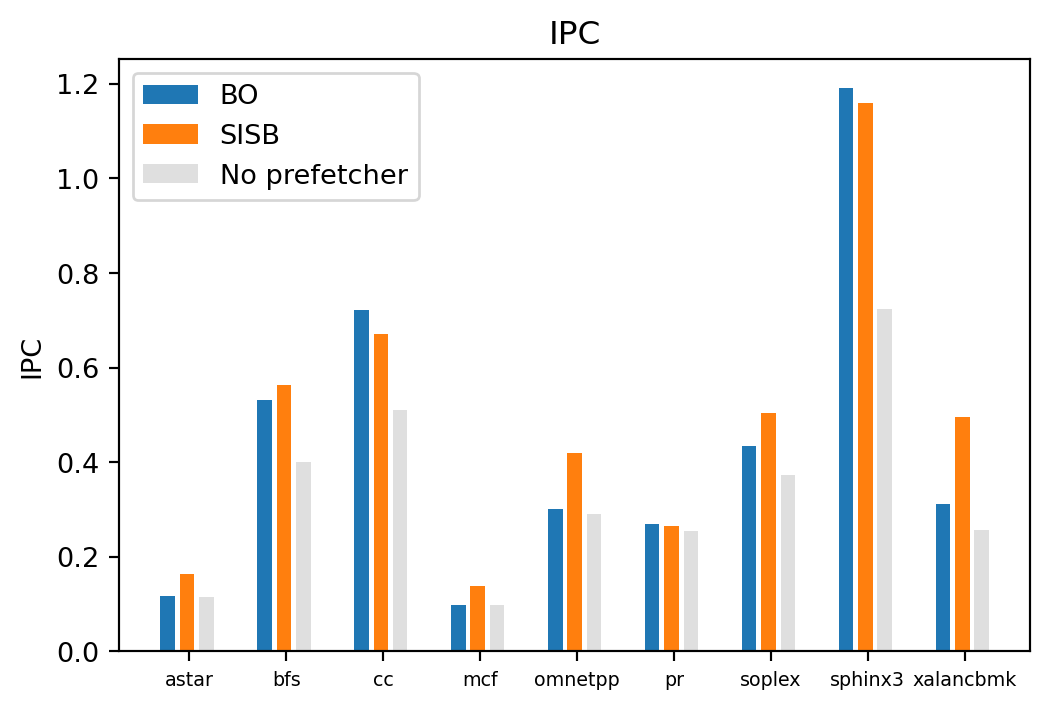

In [8]:
plot_results(
    stats, 'IPC', 'IPC',
    ymin=0,
    plot_baseline=True,
)

#### IPC speedup (vs. no prefetcher)

/tmp/ipykernel_5123/1325702672.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_5123/1325702672.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column],


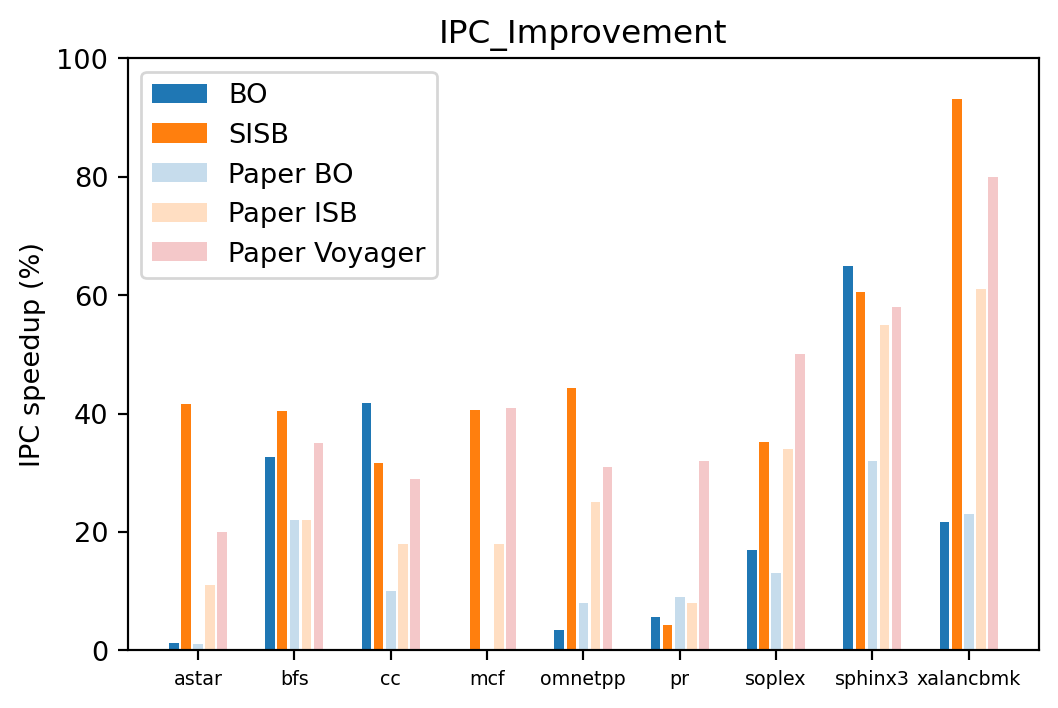

In [9]:
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv', strip_prefixes=True)

plot_results(
    stats, 'IPC_Improvement', 'IPC speedup (%)', 
    factor=100,
    ymin=0, ymax=100,
    paper_data=paper_ipc_speedups
)

/tmp/ipykernel_5123/1035460514.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sisb = tr_data[df.Baseline == 'sisb'][column].iat[0]
/tmp/ipykernel_5123/1035460514.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bo = tr_data[df.Baseline == 'bo'][column].iat[0]


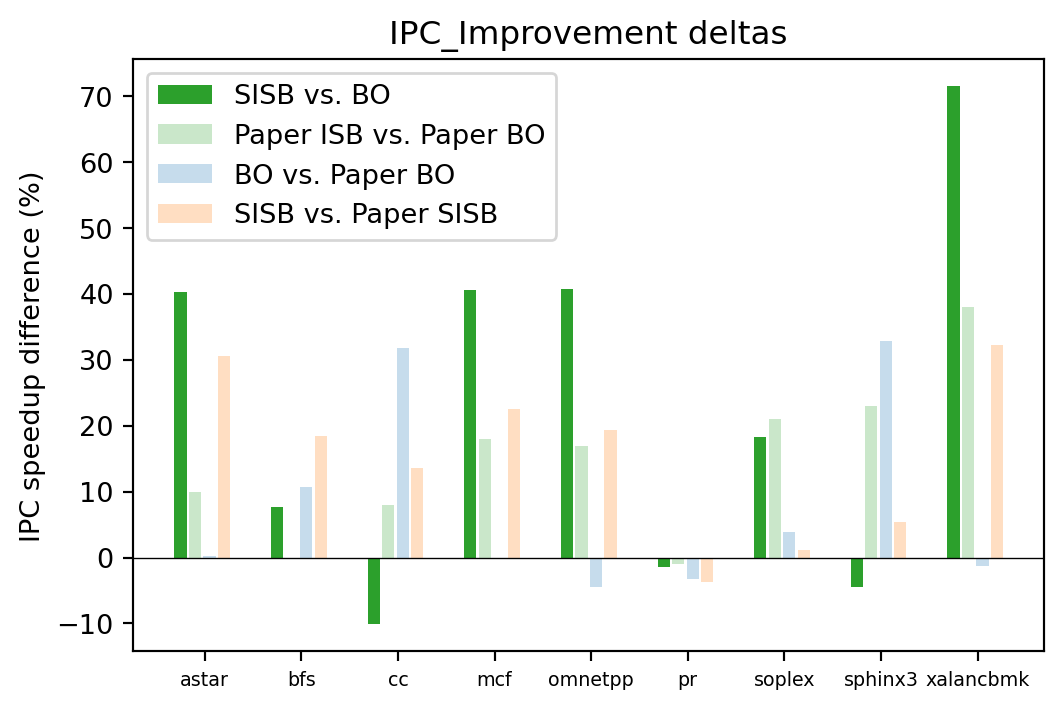

In [10]:
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv', strip_prefixes=True)

plot_deltas(
    stats, 'IPC_Improvement', 'IPC speedup difference (%)', 
    factor=100,
    paper_data=paper_ipc_speedups
)

---
# Accuracy measurements
Accuracy = useful / (useful + useless) prefetches

/tmp/ipykernel_5123/1325702672.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_5123/1325702672.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column],


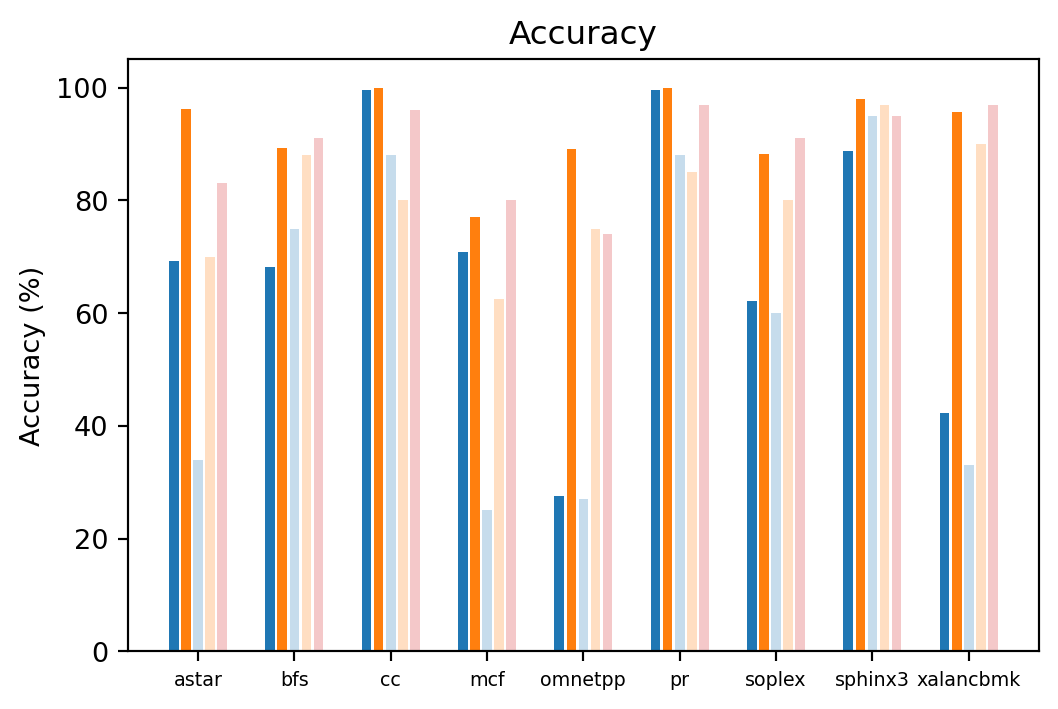

In [11]:
paper_accs = parse_paper_result_file('data/paper-values/paper_accuracies.csv', strip_prefixes=True)

plot_results(
    stats, 'Accuracy', 'Accuracy (%)', 
    factor=100,
    ymin=0, ymax=105,
    paper_data=paper_accs,
    legend=False
)

/tmp/ipykernel_5123/1035460514.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sisb = tr_data[df.Baseline == 'sisb'][column].iat[0]
/tmp/ipykernel_5123/1035460514.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bo = tr_data[df.Baseline == 'bo'][column].iat[0]


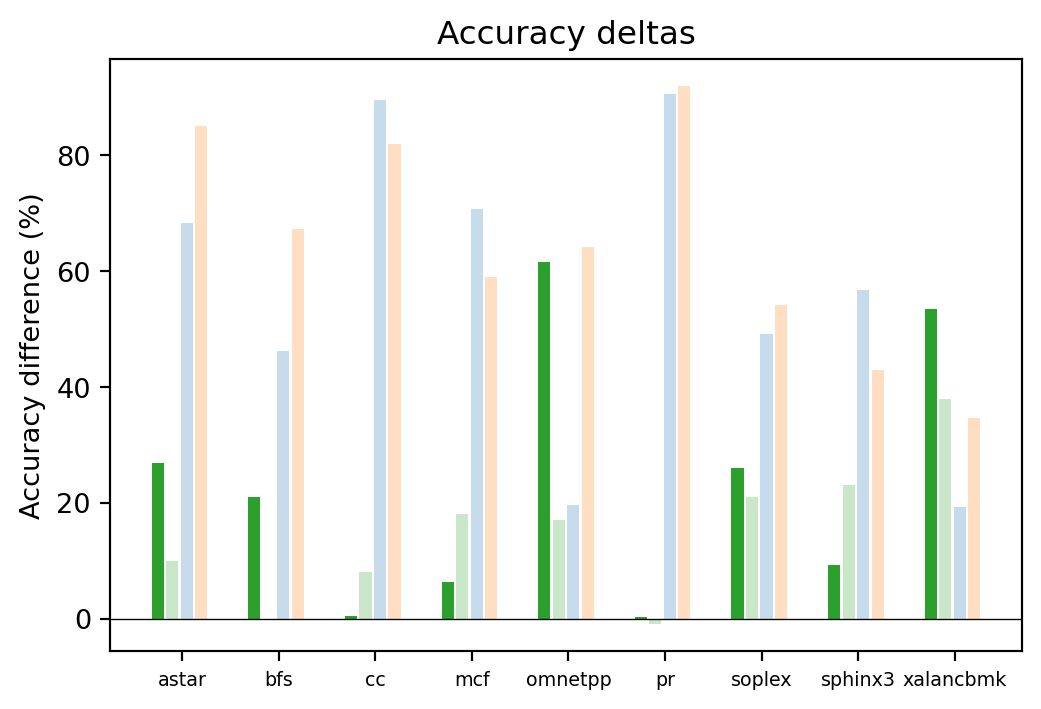

In [12]:
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv', strip_prefixes=True)

plot_deltas(
    stats, 'Accuracy', 'Accuracy difference (%)', 
    factor=100,
    paper_data=paper_ipc_speedups,
    legend=False
)

---
# Coverage measurements
Coverage = Percent decrease of:
- \# of LLC load + RFO misses on a prefetcher
- vs. # of LLC load + RFO misses on baseline (NoPrefetcher)

/tmp/ipykernel_5123/1325702672.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_5123/1325702672.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column],


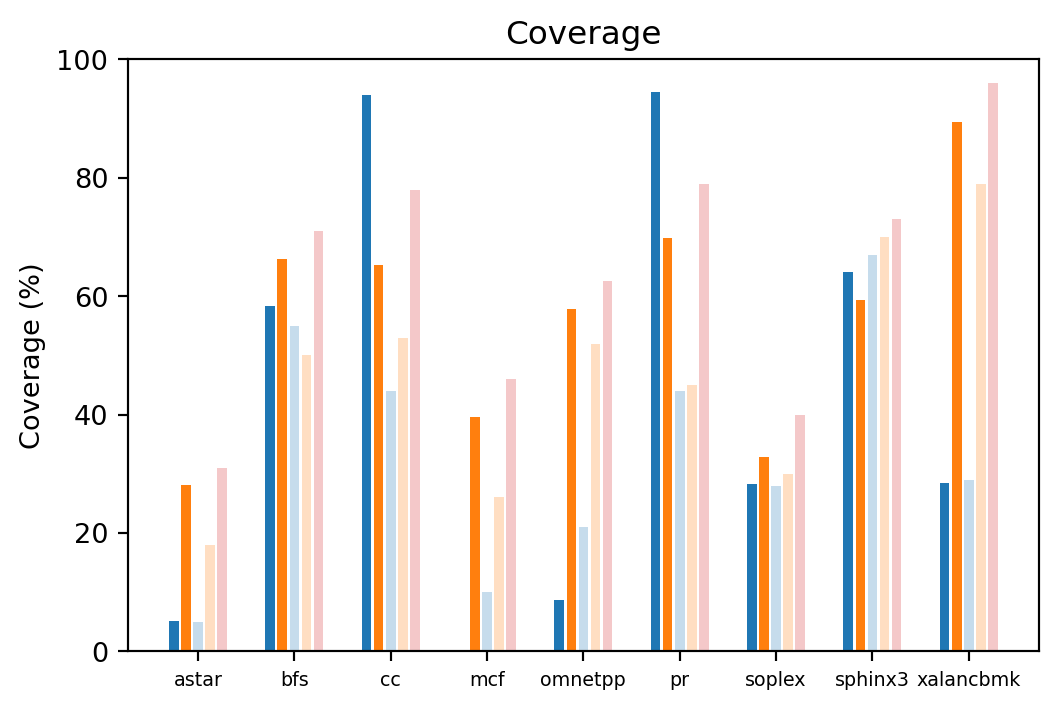

In [13]:
paper_covs = parse_paper_result_file('data/paper-values/paper_coverages.csv', strip_prefixes=True)
paper_covs

plot_results(
    stats, 'Coverage', 'Coverage (%)',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_covs,
    legend=False
)

/tmp/ipykernel_5123/1035460514.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sisb = tr_data[df.Baseline == 'sisb'][column].iat[0]
/tmp/ipykernel_5123/1035460514.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bo = tr_data[df.Baseline == 'bo'][column].iat[0]


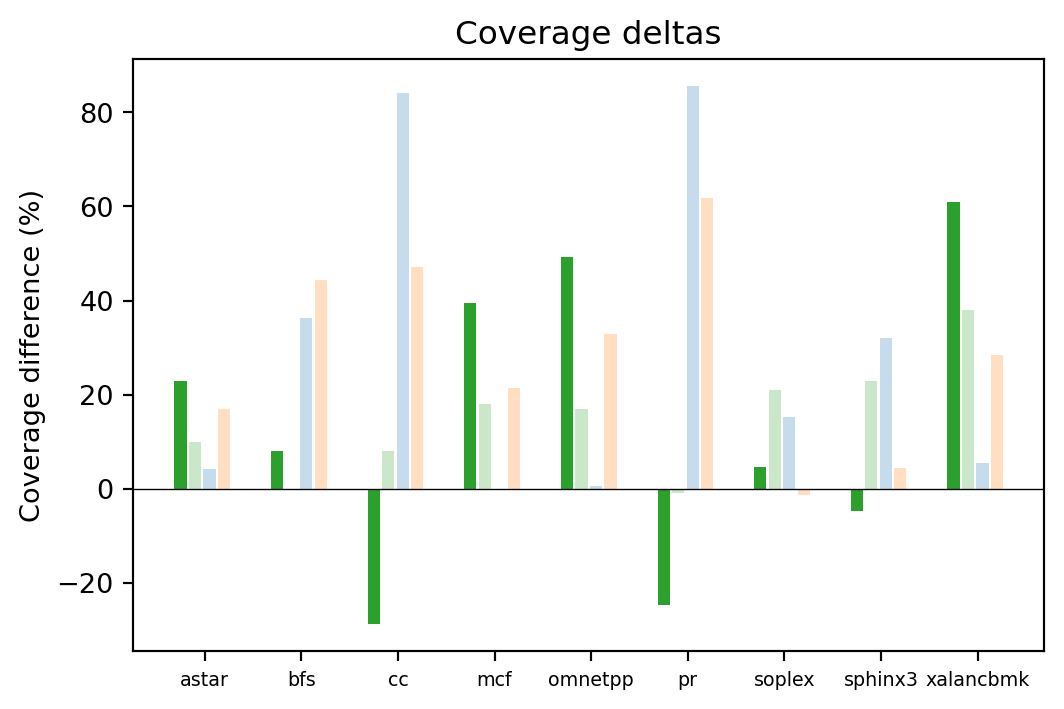

In [14]:
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv', strip_prefixes=True)

plot_deltas(
    stats, 'Coverage', 'Coverage difference (%)', 
    factor=100,
    paper_data=paper_ipc_speedups,
    legend=False
)

/tmp/ipykernel_5123/1325702672.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_5123/1325702672.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column],


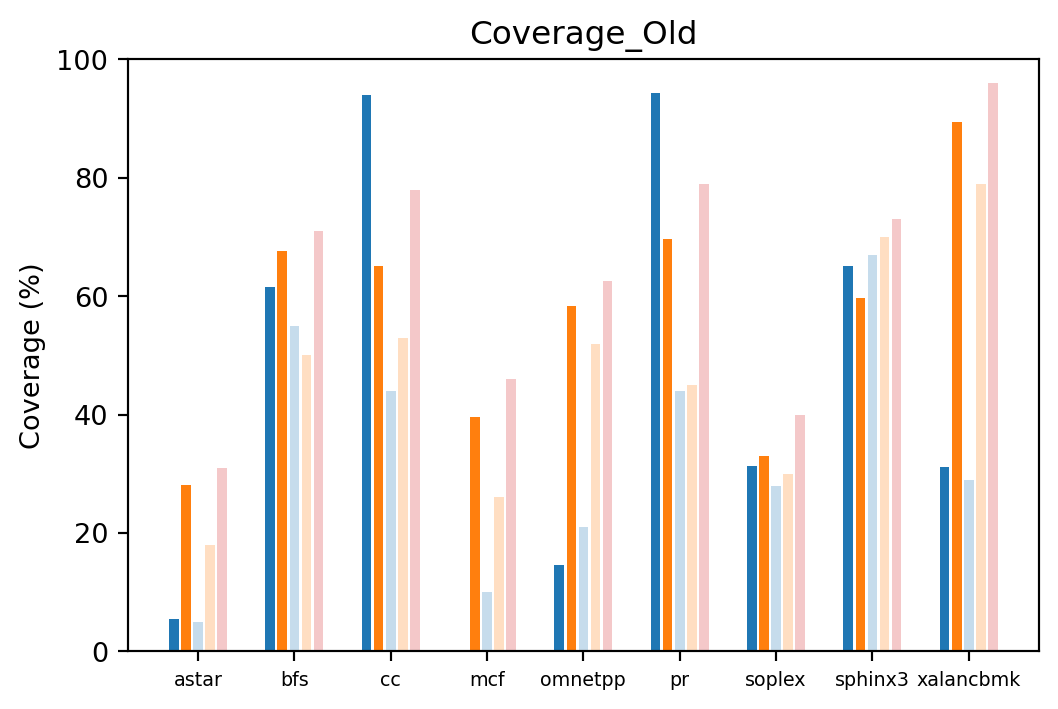

In [15]:
paper_covs = parse_paper_result_file('data/paper-values/paper_coverages.csv', strip_prefixes=True)
paper_covs

plot_results(
    stats, 'Coverage_Old', 'Coverage (%)',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_covs,
    legend=False
)

---
# Unified accuracy/coverage

## Online UACs (calculated using experimental ChampSim feature)

/tmp/ipykernel_5123/1325702672.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_5123/1325702672.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column],


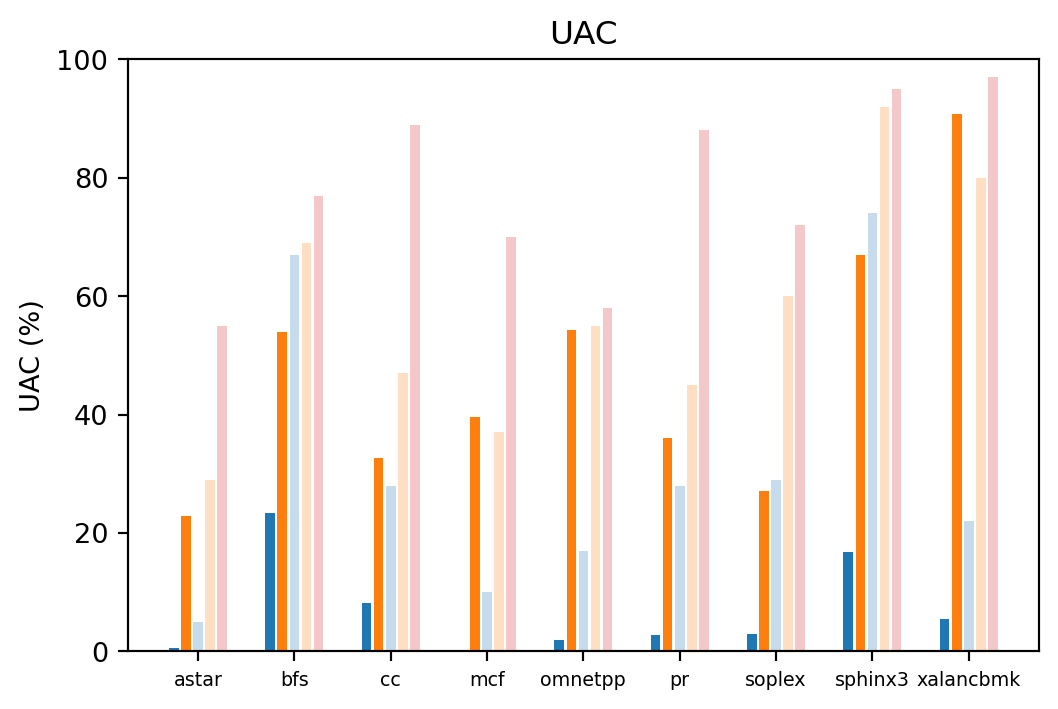

In [16]:
paper_uacs = parse_paper_result_file('data/paper-values/paper_uacs.csv', strip_prefixes=True)

plot_results(
    stats, 'UAC', 'UAC (%)',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_uacs,
    legend=False
)

/tmp/ipykernel_5123/1035460514.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sisb = tr_data[df.Baseline == 'sisb'][column].iat[0]
/tmp/ipykernel_5123/1035460514.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bo = tr_data[df.Baseline == 'bo'][column].iat[0]


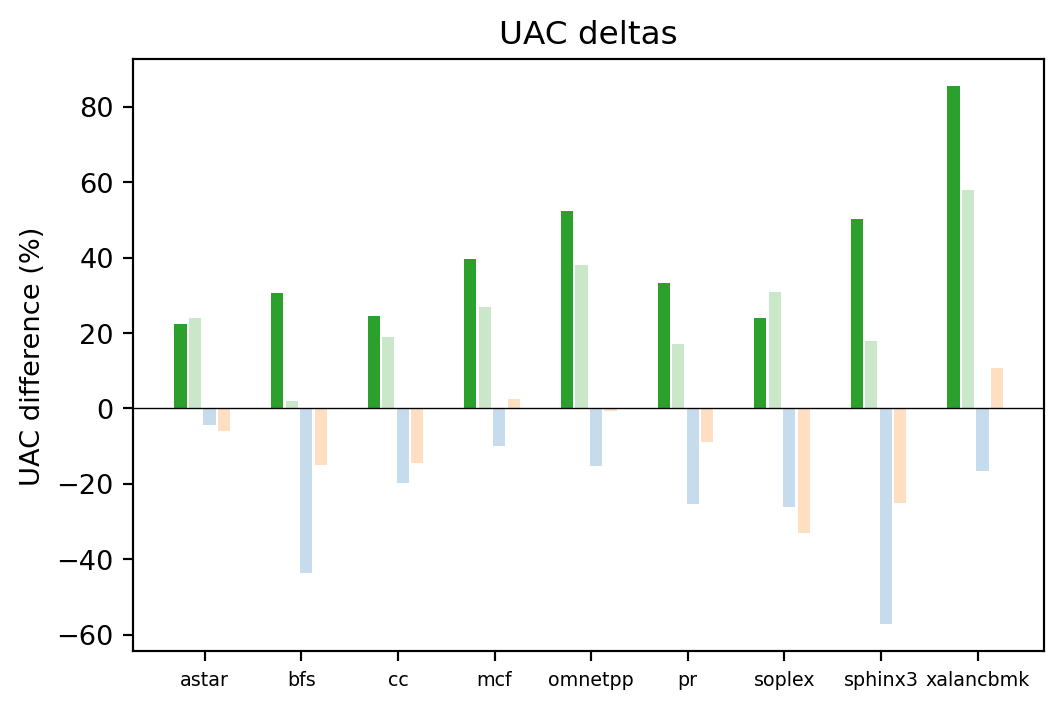

In [17]:
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv', strip_prefixes=True)

plot_deltas(
    stats, 'UAC', 'UAC difference (%)', 
    factor=100,
    paper_data=paper_uacs,
    legend=False
)

## Offline UACs (calculated using `prefetch` scripts)

/tmp/ipykernel_5123/1325702672.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i*sep, tr_data[df.Baseline == 'bo'][column],
/tmp/ipykernel_5123/1325702672.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.bar(i + nsteps*step_size, tr_data[df.Baseline == 'sisb'][column],


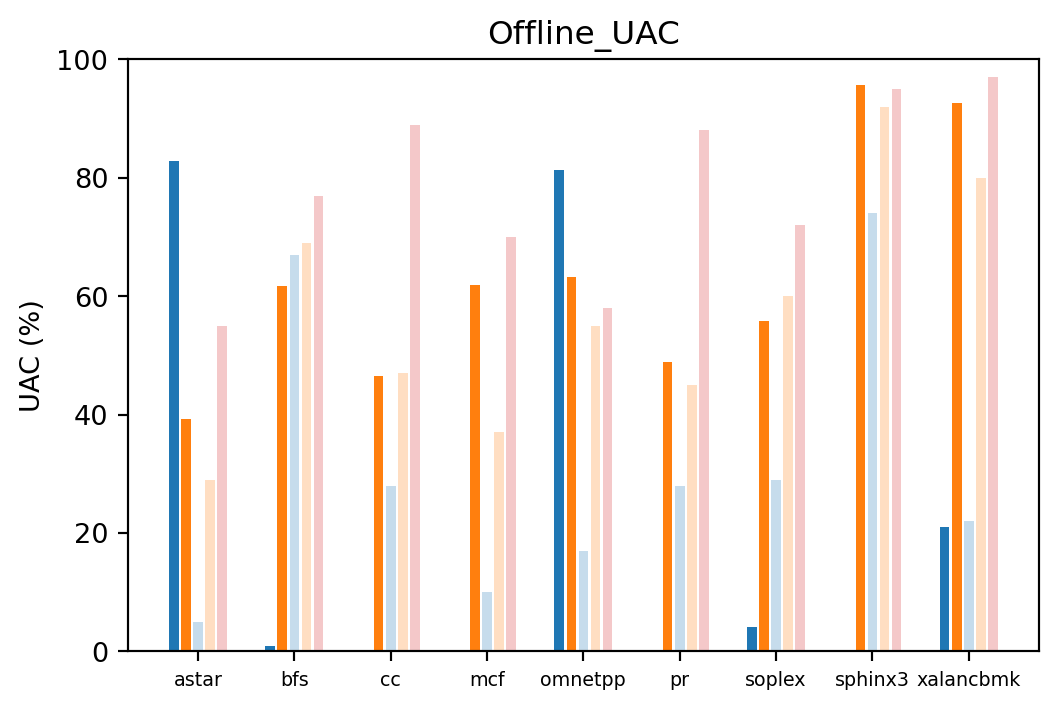

In [18]:
paper_uacs = parse_paper_result_file('data/paper-values/paper_uacs.csv', strip_prefixes=True)

plot_results(
    stats, 'Offline_UAC', 'UAC (%)',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_uacs,
    legend=False
)

/tmp/ipykernel_5123/1035460514.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sisb = tr_data[df.Baseline == 'sisb'][column].iat[0]
/tmp/ipykernel_5123/1035460514.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bo = tr_data[df.Baseline == 'bo'][column].iat[0]


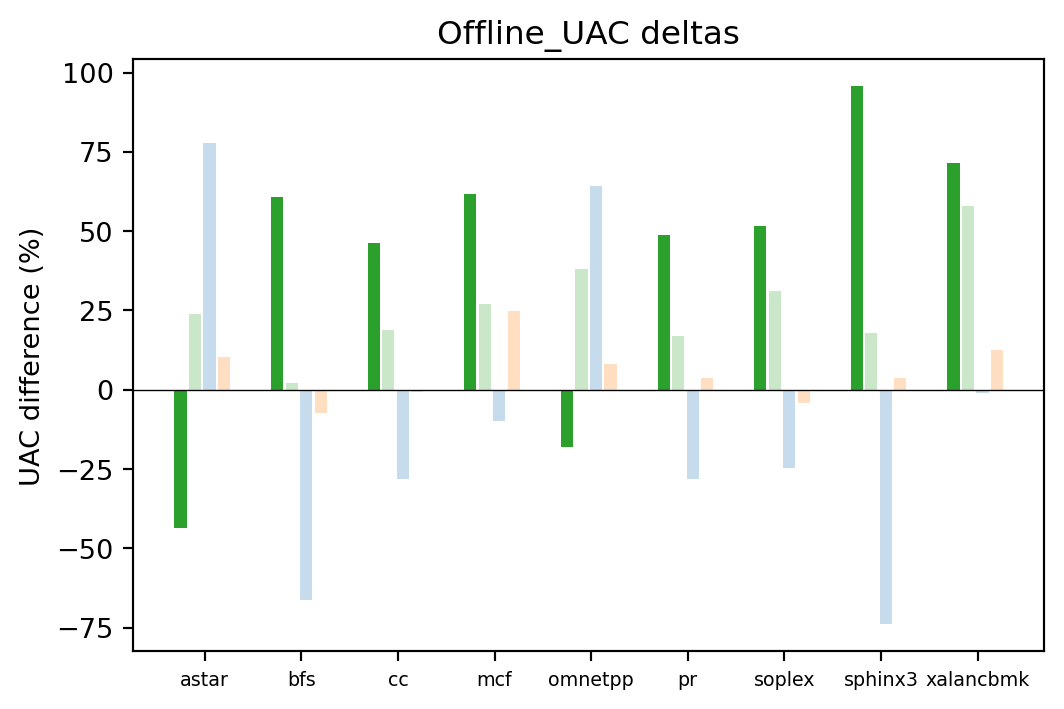

In [19]:
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv', strip_prefixes=True)

plot_deltas(
    stats, 'Offline_UAC', 'UAC difference (%)', 
    factor=100,
    paper_data=paper_uacs,
    legend=False
)